In [2]:
!pip install -q pandas seaborn statsmodels


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python -m pip install --upgrade pip


In [3]:
experiment_name = "test6_all_timeprompt_gpt3.5_1000"

2024-06-08 20:27:57.957625: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-08 20:27:57.963065: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-08 20:27:58.010545: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-08 20:27:58.902456: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


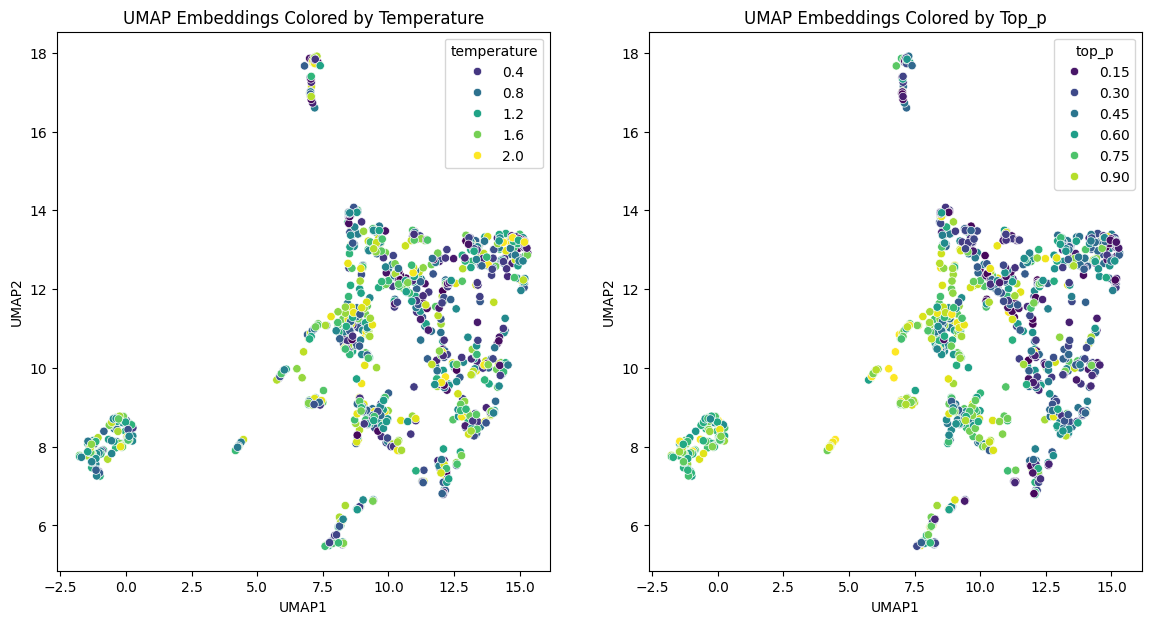

                UMAP1     UMAP2  temperature     top_p  token_count  \
UMAP1        1.000000  0.309953    -0.143153 -0.396167    -0.027792   
UMAP2        0.309953  1.000000    -0.113862 -0.237395     0.610133   
temperature -0.143153 -0.113862     1.000000  0.005887    -0.009727   
top_p       -0.396167 -0.237395     0.005887  1.000000     0.033406   
token_count -0.027792  0.610133    -0.009727  0.033406     1.000000   
max_tokens  -0.043960  0.565260    -0.001224  0.052444     0.925291   

             max_tokens  
UMAP1         -0.043960  
UMAP2          0.565260  
temperature   -0.001224  
top_p          0.052444  
token_count    0.925291  
max_tokens     1.000000  


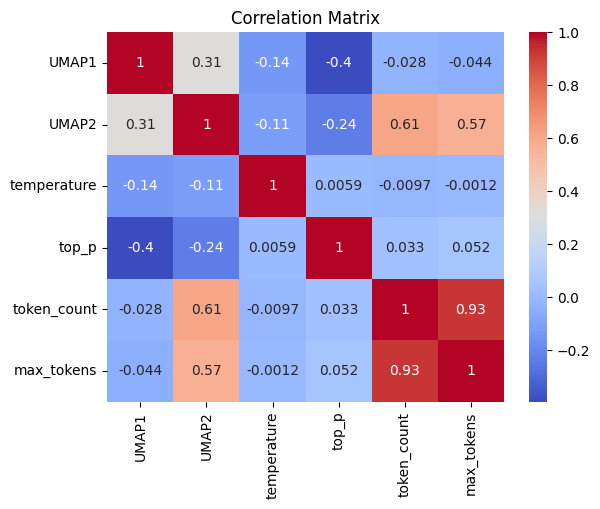

Regression results for UMAP1:
                            OLS Regression Results                            
Dep. Variable:                  UMAP1   R-squared:                       0.178
Model:                            OLS   Adj. R-squared:                  0.174
Method:                 Least Squares   F-statistic:                     53.70
Date:                Sat, 08 Jun 2024   Prob (F-statistic):           5.20e-41
Time:                        20:28:17   Log-Likelihood:                -2774.6
No. Observations:                1000   AIC:                             5559.
Df Residuals:                     995   BIC:                             5584.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          14.18

In [4]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import umap.umap_ as umap

# Set this variable to "large" or "small" to choose the embedding type
embedding_type = "large"  # or "large"

# Set the data directory path
data_dir = f"/workspace/slice-monorepo/thebeast/chat_pipeline/data/{experiment_name}"

# Initialize lists to store the data
umap1, umap2 = [], []
temperatures, top_ps, token_counts, max_tokens = [], [], [], []
embeddings_list = []

# Iterate through each step directory to load data
for step in sorted(os.listdir(data_dir)):
    step_dir = os.path.join(data_dir, step)
    if os.path.isdir(step_dir):
        step_config_file = os.path.join(step_dir, 'step_config.json')
        uuid_response_file = os.path.join(step_dir, 'uuid_response_list.json')

        if os.path.exists(step_config_file) and os.path.exists(uuid_response_file):
            # Load step configuration data
            with open(step_config_file, 'r') as f:
                step_config = json.load(f)
            
            # Load UUID response data
            with open(uuid_response_file, 'r') as f:
                uuid_responses = json.load(f)

            # Collecting embedding data
            embeddings_dir = os.path.join(step_dir, 'embeddings')
            if os.path.exists(embeddings_dir):
                for embed_file in os.listdir(embeddings_dir):
                    if embed_file.endswith('.json'):  # Ensure the file is a JSON file
                        with open(os.path.join(embeddings_dir, embed_file), 'r') as f:
                            embed_data = json.load(f)
                            for embedding_entry in embed_data['embeddings']:
                                if embedding_entry['model_name'].endswith(embedding_type):
                                    embeddings_list.append(embedding_entry['embedding'])
                                    response_uuid = embed_data['uuid']

                                    # Find the corresponding configuration from uuid_responses
                                    for response in uuid_responses:
                                        if response['uuid'] == response_uuid:
                                            response_config = response['configuration']
                                            temperatures.append(response_config['temperature'])
                                            top_ps.append(response_config['top_p'])
                                            max_tokens.append(response_config['max_tokens'])
                                            token_counts.append(len(response['response_content'].split()))
                                            break

# Convert embeddings to a NumPy array
# Ensure all embeddings have the same dimension
embedding_length = len(embeddings_list[0])
embeddings_list = [embedding for embedding in embeddings_list if len(embedding) == embedding_length]
embeddings = np.array(embeddings_list)

# Normalize embeddings
embeddings = (embeddings - embeddings.mean(axis=0)) / embeddings.std(axis=0)

# Perform UMAP
n_neighbors = max(2, min(15, len(embeddings) - 1))  # Ensure n_neighbors is at least 2
reducer = umap.UMAP(n_components=2, n_neighbors=n_neighbors, min_dist=0.1, random_state=42)
umap_results = reducer.fit_transform(embeddings)

# Create a DataFrame with UMAP results and hyperparameters
data = pd.DataFrame({
    'UMAP1': umap_results[:, 0],
    'UMAP2': umap_results[:, 1],
    'temperature': temperatures[:len(umap_results)],
    'top_p': top_ps[:len(umap_results)],
    'token_count': token_counts[:len(umap_results)],
    'max_tokens': max_tokens[:len(umap_results)]
})

# Visualize the data
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
sns.scatterplot(x='UMAP1', y='UMAP2', hue='temperature', data=data, palette='viridis')
plt.title('UMAP Embeddings Colored by Temperature')
plt.subplot(1, 2, 2)
sns.scatterplot(x='UMAP1', y='UMAP2', hue='top_p', data=data, palette='viridis')
plt.title('UMAP Embeddings Colored by Top_p')
plt.show()

# Calculate the correlation matrix
correlation_matrix = data[['UMAP1', 'UMAP2', 'temperature', 'top_p', 'token_count', 'max_tokens']].corr()
print(correlation_matrix)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Regression Analysis
X = data[['temperature', 'top_p', 'token_count', 'max_tokens']]
X = sm.add_constant(X)  # Adds a constant term to the predictors
y_umap1 = data['UMAP1']
y_umap2 = data['UMAP2']

model_umap1 = sm.OLS(y_umap1, X).fit()
model_umap2 = sm.OLS(y_umap2, X).fit()

print("Regression results for UMAP1:")
print(model_umap1.summary())
print("\nRegression results for UMAP2:")
print(model_umap2.summary())


In [5]:
# Import necessary libraries
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

data_dir = f"data/{experiment_name}"

# Initialize lists to store the data
umap1, umap2 = [], []
temperatures, top_ps, token_counts, max_tokens = [], [], [], []

# Iterate through each step directory to load data
for step in sorted(os.listdir(data_dir)):
    step_dir = os.path.join(data_dir, step)
    if os.path.isdir(step_dir):
        umap_data_file = os.path.join(step_dir, 'umap_data.json')
        step_config_file = os.path.join(step_dir, 'step_config.json')
        uuid_response_file = os.path.join(step_dir, 'uuid_response_list.json')

        if os.path.exists(umap_data_file) and os.path.exists(step_config_file) and os.path.exists(uuid_response_file):
            # Load UMAP data
            with open(umap_data_file, 'r') as f:
                umap_data = json.load(f)
            umap_embeddings = np.array(umap_data['embeddings'])
            
            # Load step configuration data
            with open(step_config_file, 'r') as f:
                step_config = json.load(f)
            
            # Load UUID response data
            with open(uuid_response_file, 'r') as f:
                uuid_responses = json.load(f)
            
            # Append data to lists
            for i in range(len(umap_embeddings)):
                umap1.append(umap_embeddings[i][0])
                umap2.append(umap_embeddings[i][1])
                response_config = uuid_responses[i]['configuration']
                temperatures.append(response_config['temperature'])
                top_ps.append(response_config['top_p'])
                max_tokens.append(response_config['max_tokens'])
                token_counts.append(len(uuid_responses[i]['response_content'].split()))

# Create a DataFrame
data = pd.DataFrame({
    'UMAP1': umap1,
    'UMAP2': umap2,
    'temperature': temperatures,
    'top_p': top_ps,
    'token_count': token_counts,
    'max_tokens': max_tokens
})

# Visualize the data
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
sns.scatterplot(x='UMAP1', y='UMAP2', hue='temperature', data=data, palette='viridis')
plt.title('UMAP Embeddings Colored by Temperature')
plt.subplot(1, 2, 2)
sns.scatterplot(x='UMAP1', y='UMAP2', hue='top_p', data=data, palette='viridis')
plt.title('UMAP Embeddings Colored by Top_p')
plt.show()

# Calculate the correlation matrix
correlation_matrix = data[['UMAP1', 'UMAP2', 'temperature', 'top_p', 'token_count', 'max_tokens']].corr()
print(correlation_matrix)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Regression Analysis
X = data[['temperature', 'top_p', 'token_count', 'max_tokens']]
X = sm.add_constant(X)  # Adds a constant term to the predictors
y_umap1 = data['UMAP1']
y_umap2 = data['UMAP2']

model_umap1 = sm.OLS(y_umap1, X).fit()
model_umap2 = sm.OLS(y_umap2, X).fit()

print("Regression results for UMAP1:")
print(model_umap1.summary())
print("\nRegression results for UMAP2:")
print(model_umap2.summary())


FileNotFoundError: [Errno 2] No such file or directory: 'data/test6_all_timeprompt_gpt3.5_1000'

In [ ]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import umap.umap_ as umap

data_dir = f"data/{experiment_name}"

# Initialize lists to store the data
umap1, umap2 = [], []
temperatures, top_ps, token_counts, max_tokens = [], [], [], []
embeddings_list = []

# Iterate through each step directory to load data
for step in sorted(os.listdir(data_dir)):
    step_dir = os.path.join(data_dir, step)
    if os.path.isdir(step_dir):
        step_config_file = os.path.join(step_dir, 'step_config.json')
        uuid_response_file = os.path.join(step_dir, 'uuid_response_list.json')

        if os.path.exists(step_config_file) and os.path.exists(uuid_response_file):
            # Load step configuration data
            with open(step_config_file, 'r') as f:
                step_config = json.load(f)
            
            # Load UUID response data
            with open(uuid_response_file, 'r') as f:
                uuid_responses = json.load(f)

            # Collecting embedding data
            embeddings_dir = os.path.join(step_dir, 'embeddings')
            if os.path.exists(embeddings_dir):
                for embed_file in os.listdir(embeddings_dir):
                    with open(os.path.join(embeddings_dir, embed_file), 'r') as f:
                        embed_data = json.load(f)
                        for embedding_entry in embed_data['embeddings']:
                            embeddings_list.append(embedding_entry['embedding'])
                            response_uuid = embed_data['uuid']

                            # Find the corresponding configuration from uuid_responses
                            for response in uuid_responses:
                                if response['uuid'] == response_uuid:
                                    response_config = response['configuration']
                                    temperatures.append(response_config['temperature'])
                                    top_ps.append(response_config['top_p'])
                                    max_tokens.append(response_config['max_tokens'])
                                    token_counts.append(len(response['response_content'].split()))
                                    break

# Convert embeddings to a NumPy array
# Ensure all embeddings have the same dimension
embedding_length = len(embeddings_list[0])
embeddings_list = [embedding for embedding in embeddings_list if len(embedding) == embedding_length]
embeddings = np.array(embeddings_list)

# Normalize embeddings
embeddings = (embeddings - embeddings.mean(axis=0)) / embeddings.std(axis=0)

# Perform UMAP
n_neighbors = max(2, min(15, len(embeddings) - 1))  # Ensure n_neighbors is at least 2
reducer = umap.UMAP(n_components=2, n_neighbors=n_neighbors, min_dist=0.1, random_state=42)
umap_results = reducer.fit_transform(embeddings)

# Create a DataFrame with UMAP results and hyperparameters
data = pd.DataFrame({
    'UMAP1': umap_results[:, 0],
    'UMAP2': umap_results[:, 1],
    'temperature': temperatures[:len(umap_results)],
    'top_p': top_ps[:len(umap_results)],
    'token_count': token_counts[:len(umap_results)],
    'max_tokens': max_tokens[:len(umap_results)]
})

# Visualize the data
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
sns.scatterplot(x='UMAP1', y='UMAP2', hue='temperature', data=data, palette='viridis')
plt.title('UMAP Embeddings Colored by Temperature')
plt.subplot(1, 2, 2)
sns.scatterplot(x='UMAP1', y='UMAP2', hue='top_p', data=data, palette='viridis')
plt.title('UMAP Embeddings Colored by Top_p')
plt.show()

# Calculate the correlation matrix
correlation_matrix = data[['UMAP1', 'UMAP2', 'temperature', 'top_p', 'token_count', 'max_tokens']].corr()
print(correlation_matrix)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Regression Analysis
X = data[['temperature', 'top_p', 'token_count', 'max_tokens']]
X = sm.add_constant(X)  # Adds a constant term to the predictors
y_umap1 = data['UMAP1']
y_umap2 = data['UMAP2']

model_umap1 = sm.OLS(y_umap1, X).fit()
model_umap2 = sm.OLS(y_umap2, X).fit()

print("Regression results for UMAP1:")
print(model_umap1.summary())
print("\nRegression results for UMAP2:")
print(model_umap2.summary())


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.spatial.distance import jaccard
from difflib import SequenceMatcher

# Define a function to compare texts
def compare_texts(text1, text2):
    tfidf = TfidfVectorizer().fit_transform([text1, text2])
    cosine_sim = cosine_similarity(tfidf)[0, 1]
    sequence_sim = SequenceMatcher(None, text1, text2).ratio()
    return cosine_sim, sequence_sim

# Identify pairs of UMAP points that are extremely close
threshold_distance = 0.01  # Adjust this threshold based on your data
close_pairs = []
for i in range(len(umap_results)):
    for j in range(i + 1, len(umap_results)):
        distance = np.linalg.norm(umap_results[i] - umap_results[j])
        if distance < threshold_distance:
            close_pairs.append((i, j))

# Compare close pairs of text embeddings and original text
print("Comparing close UMAP points:")
for idx, (i, j) in enumerate(close_pairs[:5]):  # Print only a few examples
    print(f"Pair ({i}, {j}):")
    print(f"Text 1: {data.loc[i, 'original_text']}")
    print(f"Text 2: {data.loc[j, 'original_text']}")
    cosine_sim, sequence_sim = compare_texts(data.loc[i, 'original_text'], data.loc[j, 'original_text'])
    embedding_cosine_sim = cosine_similarity([embeddings[i]], [embeddings[j]])[0, 0]
    print(f"Text Cosine Similarity: {cosine_sim}")
    print(f"Text Sequence Similarity: {sequence_sim}")
    print(f"Embedding Cosine Similarity: {embedding_cosine_sim}")
    print("")

# Calculate the cosine similarity matrix for embeddings
embedding_similarity_matrix = cosine_similarity(embeddings)

# Compare the similarity matrix with the UMAP distances
umap_distances = np.linalg.norm(umap_results[:, np.newaxis, :] - umap_results[np.newaxis, :, :], axis=-1)

# Flatten matrices for correlation
embedding_sim_flat = embedding_similarity_matrix[np.triu_indices_from(embedding_similarity_matrix, k=1)]
umap_dist_flat = umap_distances[np.triu_indices_from(umap_distances, k=1)]

# Calculate correlation
embedding_umap_correlation = np.corrcoef(embedding_sim_flat, umap_dist_flat)[0, 1]
print(f"Correlation between embedding similarities and UMAP distances: {embedding_umap_correlation}")

# Plot similarity vs. distance
plt.scatter(embedding_sim_flat, umap_dist_flat, alpha=0.5)
plt.xlabel('Embedding Cosine Similarity')
plt.ylabel('UMAP Distance')
plt.title('Embedding Similarity vs. UMAP Distance')
plt.show()


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.spatial.distance import jaccard
from difflib import SequenceMatcher
from sklearn.decomposition import PCA

# Define a function to compare texts using multiple similarity measures
def compare_texts(text1, text2):
    tfidf = TfidfVectorizer().fit_transform([text1, text2])
    cosine_sim = cosine_similarity(tfidf)[0, 1]
    sequence_sim = SequenceMatcher(None, text1, text2).ratio()
    return cosine_sim, sequence_sim

# Identify pairs of UMAP points that are extremely close
threshold_distance = 0.01  # Adjust this threshold based on your data
close_pairs = []
for i in range(len(umap_results)):
    for j in range(i + 1, len(umap_results)):
        distance = np.linalg.norm(umap_results[i] - umap_results[j])
        if distance < threshold_distance:
            close_pairs.append((i, j))

# Compare close pairs of text embeddings and original text
print("Comparing close UMAP points:")
for idx, (i, j) in enumerate(close_pairs[:5]):  # Print only a few examples
    print(f"Pair ({i}, {j}):")
    print(f"Text 1: {data.loc[i, 'original_text']}")
    print(f"Text 2: {data.loc[j, 'original_text']}")
    cosine_sim, sequence_sim = compare_texts(data.loc[i, 'original_text'], data.loc[j, 'original_text'])
    embedding_cosine_sim = cosine_similarity([embeddings[i]], [embeddings[j]])[0, 0]
    print(f"Text Cosine Similarity: {cosine_sim}")
    print(f"Text Sequence Similarity: {sequence_sim}")
    print(f"Embedding Cosine Similarity: {embedding_cosine_sim}")
    print("")

# Perform PCA for comparison with UMAP
pca = PCA(n_components=2)
pca_results = pca.fit_transform(embeddings)

# Create a DataFrame with PCA results
pca_data = pd.DataFrame({
    'PCA1': pca_results[:, 0],
    'PCA2': pca_results[:, 1],
    'temperature': temperatures[:len(pca_results)],
    'top_p': top_ps[:len(pca_results)],
    'token_count': token_counts[:len(pca_results)],
    'max_tokens': max_tokens[:len(pca_results)]
})

# Visualize the PCA results
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
sns.scatterplot(x='PCA1', y='PCA2', hue='temperature', data=pca_data, palette='viridis')
plt.title('PCA Embeddings Colored by Temperature')
plt.subplot(1, 2, 2)
sns.scatterplot(x='PCA1', y='PCA2', hue='top_p', data=pca_data, palette='viridis')
plt.title('PCA Embeddings Colored by Top_p')
plt.show()

# Calculate the correlation matrix for PCA
correlation_matrix_pca = pca_data[['PCA1', 'PCA2', 'temperature', 'top_p', 'token_count', 'max_tokens']].corr()
print(correlation_matrix_pca)
sns.heatmap(correlation_matrix_pca, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix for PCA')
plt.show()

# Regression Analysis for PCA
X_pca = pca_data[['temperature', 'top_p', 'token_count', 'max_tokens']]
X_pca = sm.add_constant(X_pca)  # Adds a constant term to the predictors
y_pca1 = pca_data['PCA1']
y_pca2 = pca_data['PCA2']

model_pca1 = sm.OLS(y_pca1, X_pca).fit()
model_pca2 = sm.OLS(y_pca2, X_pca).fit()

print("Regression results for PCA1:")
print(model_pca1.summary())
print("\nRegression results for PCA2:")
print(model_pca2.summary())


In [ ]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import umap.umap_ as umap
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from difflib import SequenceMatcher
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage

data_dir = f"data/{experiment_name}"

# Initialize lists to store the data
umap1, umap2 = [], []
temperatures, top_ps, token_counts, max_tokens = [], [], [], []
embeddings_list = []
original_texts = []
uuids = []

# Iterate through each step directory to load data
for step in sorted(os.listdir(data_dir)):
    step_dir = os.path.join(data_dir, step)
    if os.path.isdir(step_dir):
        step_config_file = os.path.join(step_dir, 'step_config.json')
        uuid_response_file = os.path.join(step_dir, 'uuid_response_list.json')

        if os.path.exists(step_config_file) and os.path.exists(uuid_response_file):
            # Load step configuration data
            with open(step_config_file, 'r') as f:
                step_config = json.load(f)
            
            # Load UUID response data
            with open(uuid_response_file, 'r') as f:
                uuid_responses = json.load(f)

            # Collecting embedding data
            embeddings_dir = os.path.join(step_dir, 'embeddings')
            if os.path.exists(embeddings_dir):
                for embed_file in os.listdir(embeddings_dir):
                    with open(os.path.join(embeddings_dir, embed_file), 'r') as f:
                        embed_data = json.load(f)
                        embeddings_combined = []
                        for embedding_entry in embed_data['embeddings']:
                            embeddings_combined.extend(embedding_entry['embedding'])
                        embeddings_list.append(embeddings_combined)
                        response_uuid = embed_data['uuid']

                        # Find the corresponding configuration from uuid_responses
                        for response in uuid_responses:
                            if response['uuid'] == response_uuid:
                                response_config = response['configuration']
                                temperatures.append(response_config['temperature'])
                                top_ps.append(response_config['top_p'])
                                max_tokens.append(response_config['max_tokens'])
                                token_counts.append(len(response['response_content'].split()))
                                original_texts.append(response['response_content'])
                                uuids.append(response_uuid)
                                break

# Convert embeddings to a NumPy array
embedding_length = len(embeddings_list[0])
embeddings_list = [embedding for embedding in embeddings_list if len(embedding) == embedding_length]
embeddings = np.array(embeddings_list)

# Normalize embeddings
embeddings = (embeddings - embeddings.mean(axis=0)) / embeddings.std(axis=0)

# Perform UMAP
n_neighbors = max(2, min(15, len(embeddings) - 1))  # Ensure n_neighbors is at least 2
reducer = umap.UMAP(n_components=2, n_neighbors=n_neighbors, min_dist=0.1, random_state=42)
umap_results = reducer.fit_transform(embeddings)

# Perform t-SNE
tsne_results = TSNE(n_components=2, random_state=42).fit_transform(embeddings)

# Perform K-Means Clustering
kmeans = KMeans(n_clusters=5, random_state=42).fit(embeddings)
cluster_labels = kmeans.labels_

# Create a DataFrame with UMAP and t-SNE results and hyperparameters
data = pd.DataFrame({
    'UMAP1': umap_results[:, 0],
    'UMAP2': umap_results[:, 1],
    't-SNE1': tsne_results[:, 0],
    't-SNE2': tsne_results[:, 1],
    'Cluster': cluster_labels,
    'temperature': temperatures[:len(umap_results)],
    'top_p': top_ps[:len(umap_results)],
    'token_count': token_counts[:len(umap_results)],
    'max_tokens': max_tokens[:len(umap_results)],
    'original_text': original_texts[:len(umap_results)],
    'uuid': uuids[:len(umap_results)]
})

# Visualize the data
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
sns.scatterplot(x='UMAP1', y='UMAP2', hue='Cluster', data=data, palette='viridis')
plt.title('UMAP Embeddings Colored by Cluster')
plt.subplot(1, 2, 2)
sns.scatterplot(x='t-SNE1', y='t-SNE2', hue='Cluster', data=data, palette='viridis')
plt.title('t-SNE Embeddings Colored by Cluster')
plt.show()

# Calculate the correlation matrix
correlation_matrix = data[['UMAP1', 'UMAP2', 't-SNE1', 't-SNE2', 'Cluster', 'temperature', 'top_p', 'token_count', 'max_tokens']].corr()
print(correlation_matrix)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Regression Analysis for UMAP
X_umap = data[['temperature', 'top_p', 'token_count', 'max_tokens']]
X_umap = sm.add_constant(X_umap)  # Adds a constant term to the predictors
y_umap1 = data['UMAP1']
y_umap2 = data['UMAP2']

model_umap1 = sm.OLS(y_umap1, X_umap).fit()
model_umap2 = sm.OLS(y_umap2, X_umap).fit()

print("Regression results for UMAP1:")
print(model_umap1.summary())
print("\nRegression results for UMAP2:")
print(model_umap2.summary())

# Regression Analysis for t-SNE
X_tsne = data[['temperature', 'top_p', 'token_count', 'max_tokens']]
X_tsne = sm.add_constant(X_tsne)  # Adds a constant term to the predictors
y_tsne1 = data['t-SNE1']
y_tsne2 = data['t-SNE2']

model_tsne1 = sm.OLS(y_tsne1, X_tsne).fit()
model_tsne2 = sm.OLS(y_tsne2, X_tsne).fit()

print("Regression results for t-SNE1:")
print(model_tsne1.summary())
print("\nRegression results for t-SNE2:")
print(model_tsne2.summary())

# Hierarchical Clustering
linked = linkage(embeddings, 'ward')
plt.figure(figsize=(10, 7))
dendrogram(linked)
plt.title('Hierarchical Clustering Dendrogram')
plt.show()


In [ ]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import umap.umap_ as umap
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from difflib import SequenceMatcher
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

data_dir = f"data/{experiment_name}"

# Initialize lists to store the data
umap1, umap2 = [], []
temperatures, top_ps, token_counts, max_tokens = [], [], [], []
embeddings_list = []
original_texts = []
uuids = []

# Iterate through each step directory to load data
for step in sorted(os.listdir(data_dir)):
    step_dir = os.path.join(data_dir, step)
    if os.path.isdir(step_dir):
        step_config_file = os.path.join(step_dir, 'step_config.json')
        uuid_response_file = os.path.join(step_dir, 'uuid_response_list.json')

        if os.path.exists(step_config_file) and os.path.exists(uuid_response_file):
            # Load step configuration data
            with open(step_config_file, 'r') as f:
                step_config = json.load(f)
            
            # Load UUID response data
            with open(uuid_response_file, 'r') as f:
                uuid_responses = json.load(f)

            # Collecting embedding data
            embeddings_dir = os.path.join(step_dir, 'embeddings')
            if os.path.exists(embeddings_dir):
                for embed_file in os.listdir(embeddings_dir):
                    with open(os.path.join(embeddings_dir, embed_file), 'r') as f:
                        embed_data = json.load(f)
                        combined_embedding = np.concatenate(
                            [embedding_entry['embedding'] for embedding_entry in embed_data['embeddings']],
                            axis=None
                        )
                        embeddings_list.append(combined_embedding)
                        response_uuid = embed_data['uuid']

                        # Find the corresponding configuration from uuid_responses
                        for response in uuid_responses:
                            if response['uuid'] == response_uuid:
                                response_config = response['configuration']
                                temperatures.append(response_config['temperature'])
                                top_ps.append(response_config['top_p'])
                                max_tokens.append(response_config['max_tokens'])
                                token_counts.append(len(response['response_content'].split()))
                                original_texts.append(response['response_content'])
                                uuids.append(response_uuid)
                                break

# Convert embeddings to a NumPy array
embedding_length = len(embeddings_list[0])
embeddings_list = [embedding for embedding in embeddings_list if len(embedding) == embedding_length]
embeddings = np.array(embeddings_list)

# Normalize embeddings
embeddings = (embeddings - embeddings.mean(axis=0)) / embeddings.std(axis=0)

# Perform UMAP
n_neighbors = max(2, min(15, len(embeddings) - 1))  # Ensure n_neighbors is at least 2
reducer = umap.UMAP(n_components=2, n_neighbors=n_neighbors, min_dist=0.1, random_state=42)
umap_results = reducer.fit_transform(embeddings)

# Perform t-SNE
tsne_results = TSNE(n_components=2, random_state=42).fit_transform(embeddings)

# Perform K-Means Clustering
kmeans = KMeans(n_clusters=5, random_state=42).fit(embeddings)
cluster_labels = kmeans.labels_

# Create a DataFrame with UMAP and t-SNE results and hyperparameters
data = pd.DataFrame({
    'UMAP1': umap_results[:, 0],
    'UMAP2': umap_results[:, 1],
    't-SNE1': tsne_results[:, 0],
    't-SNE2': tsne_results[:, 1],
    'Cluster': cluster_labels,
    'temperature': temperatures[:len(umap_results)],
    'top_p': top_ps[:len(umap_results)],
    'token_count': token_counts[:len(umap_results)],
    'max_tokens': max_tokens[:len(umap_results)],
    'original_text': original_texts[:len(umap_results)],
    'uuid': uuids[:len(umap_results)]
})

# Visualize the data
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
sns.scatterplot(x='UMAP1', y='UMAP2', hue='Cluster', data=data, palette='viridis')
plt.title('UMAP Embeddings Colored by Cluster')
plt.subplot(1, 2, 2)
sns.scatterplot(x='t-SNE1', y='t-SNE2', hue='Cluster', data=data, palette='viridis')
plt.title('t-SNE Embeddings Colored by Cluster')
plt.show()

# Calculate the correlation matrix
correlation_matrix = data[['UMAP1', 'UMAP2', 't-SNE1', 't-SNE2', 'Cluster', 'temperature', 'top_p', 'token_count', 'max_tokens']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Text Similarity Analysis
def text_similarity(text1, text2):
    return SequenceMatcher(None, text1, text2).ratio()

# Comparing close UMAP points
umap_distances = np.sqrt((umap_results[:, 0][:, np.newaxis] - umap_results[:, 0]) ** 2 + (umap_results[:, 1][:, np.newaxis] - umap_results[:, 1]) ** 2)
close_points = np.where((umap_distances < 0.1) & (umap_distances > 0))

text_similarity_results = []
for i, j in zip(close_points[0], close_points[1]):
    sim = text_similarity(data.loc[i, 'original_text'], data.loc[j, 'original_text'])
    text_similarity_results.append((i, j, sim))

# Sort by similarity and print two examples
text_similarity_results = sorted(text_similarity_results, key=lambda x: x[2], reverse=True)
for k in range(2):
    i, j, sim = text_similarity_results[k]
    print(f"Text similarity between UUID {data.loc[i, 'uuid']} and UUID {data.loc[j, 'uuid']}: {sim:.2f}")
    print(f"Text 1: {data.loc[i, 'original_text']}")
    print(f"Text 2: {data.loc[j, 'original_text']}")
    print("-----")

# Summary of text similarity findings
similarities = [result[2] for result in text_similarity_results]
mean_similarity = np.mean(similarities)
std_similarity = np.std(similarities)
outliers = [result for result in text_similarity_results if result[2] < mean_similarity - 2 * std_similarity or result[2] > mean_similarity + 2 * std_similarity]

print(f"Mean text similarity: {mean_similarity:.2f}")
print(f"Standard deviation of text similarity: {std_similarity:.2f}")
print(f"Number of outliers: {len(outliers)}")

# Save data for further analysis
data.to_csv('combined_embeddings_analysis.csv', index=False)


In [ ]:
experiment_name = "test6_all_timeprompt_gpt3.5_1000"

In [ ]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.metrics import pairwise_distances
import torch
import umap.umap_ as umap
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from sklearn.feature_extraction.text import TfidfVectorizer
from difflib import SequenceMatcher

# Function to calculate perplexity
def calculate_perplexity(texts, model, tokenizer):
    perplexities = []
    for text in texts:
        input_ids = tokenizer.encode(text, return_tensors='pt').to('cuda')
        with torch.no_grad():
            outputs = model(input_ids, labels=input_ids)
            loss = outputs.loss
            perplexity = torch.exp(loss).item()
            perplexities.append(perplexity)
    return perplexities

# Function to calculate cosine similarity
def calculate_cosine_similarity(texts):
    vectorizer = TfidfVectorizer().fit_transform(texts)
    vectors = vectorizer.toarray()
    cosine_similarities = []
    for i in range(len(vectors)):
        for j in range(i + 1, len(vectors)):
            similarity = np.dot(vectors[i], vectors[j]) / (np.linalg.norm(vectors[i]) * np.linalg.norm(vectors[j]))
            cosine_similarities.append(similarity)
    return cosine_similarities

# Function to calculate edit distance
def calculate_edit_distance(text1, text2):
    return SequenceMatcher(None, text1, text2).ratio()

# Function to normalize edit distance
def calculate_normalized_edit_distance(texts):
    edit_distances = []
    for i in range(len(texts)):
        for j in range(i + 1, len(texts)):
            distance = calculate_edit_distance(texts[i], texts[j])
            edit_distances.append(distance)
    return edit_distances

data_dir = f"data/{experiment_name}"

# Initialize lists to store the data
original_texts = []
temperatures = []

# Iterate through each step directory to load data
for step in sorted(os.listdir(data_dir)):
    step_dir = os.path.join(data_dir, step)
    if os.path.isdir(step_dir):
        step_config_file = os.path.join(step_dir, 'step_config.json')
        uuid_response_file = os.path.join(step_dir, 'uuid_response_list.json')

        if os.path.exists(step_config_file) and os.path.exists(uuid_response_file):
            # Load step configuration data
            with open(step_config_file, 'r') as f:
                step_config = json.load(f)
            
            # Load UUID response data
            with open(uuid_response_file, 'r') as f:
                uuid_responses = json.load(f)
            
            for response in uuid_responses:
                response_config = response['configuration']
                temperatures.append(response_config['temperature'])
                original_texts.append(response['response_content'])

# Load GPT-2 model and tokenizer
model_name = 'gpt2'
model = GPT2LMHeadModel.from_pretrained(model_name).to('cuda')
tokenizer = GPT2Tokenizer.from_pretrained(model_name)

# Calculate perplexity
perplexities = calculate_perplexity(original_texts, model, tokenizer)

# Calculate cosine similarity
cosine_similarities = calculate_cosine_similarity(original_texts)

# Calculate normalized edit distance
edit_distances = calculate_normalized_edit_distance(original_texts)

# Create DataFrame for analysis
data = pd.DataFrame({
    'temperature': temperatures,
    'perplexity': perplexities,
    'cosine_similarity': cosine_similarities,
    'edit_distance': edit_distances[:len(cosine_similarities)]  # Ensure same length for simplicity
})

# Categorize temperatures into bins
data['temperature_bin'] = pd.cut(data['temperature'], bins=[0, 0.5, 1.0, 1.5, 2.0, 2.5], labels=['0-0.5', '0.5-1.0', '1.0-1.5', '1.5-2.0', '2.0-2.5'])

# Plotting
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x='temperature_bin', y='perplexity', data=data, palette='viridis')
plt.title('Perplexity vs Temperature')

plt.subplot(1, 3, 2)
sns.boxplot(x='temperature_bin', y='cosine_similarity', data=data, palette='viridis')
plt.title('Cosine Similarity vs Temperature')

plt.subplot(1, 3, 3)
sns.boxplot(x='temperature_bin', y='edit_distance', data=data, palette='viridis')
plt.title('Edit Distance vs Temperature')

plt.tight_layout()
plt.show()
